# Importing Libraries

In [14]:
!pip install --quiet fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import fastf1
import fastf1.plotting

fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False,color_scheme='fastf1')

/usr/local/lib/python3.11/dist-packages/fastf1/plotting/_plotting.py:57: FutureWarning: The `misc_mpl_mods` argument was dropped from `.setup_mpl()` in version 3.6.0 and has no effect anymore. It will be removed in a future version of FastF1.
  warnings.warn(


In [2]:
race = fastf1.get_session(2025, 14, 'R')
race.load()
laps = race.laps

req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) /root/.cache/fastf1
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Lo

In [3]:
quick_laps = race.laps.pick_quicklaps()

transformed_laps = quick_laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

# order the team from the fastest (lowest median lap time) tp slower
team_median_lap_time = transformed_laps[["Team", "LapTime (s)"]]\
    .groupby("Team")\
    .median()["LapTime (s)"]\
    .sort_values()

team_order = team_median_lap_time.index
min_lap_time = team_median_lap_time.iloc[0]
team_median_lap_time_difference = team_median_lap_time - min_lap_time

print(team_order)

# make a color palette associating team names to hex codes
team_palette = {team: fastf1.plotting.get_team_color(team, session=race)
                for team in team_order}

req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info


Index(['McLaren', 'Mercedes', 'Ferrari', 'Red Bull Racing', 'Aston Martin',
       'Kick Sauber', 'Williams', 'Alpine', 'Racing Bulls', 'Haas F1 Team'],
      dtype='object', name='Team')


/tmp/ipython-input-3033571426.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = transformed_laps['Driver'], y=transformed_laps['LapTime (s)'], palette=fastf1.plotting.get_driver_color_mapping(session=race))


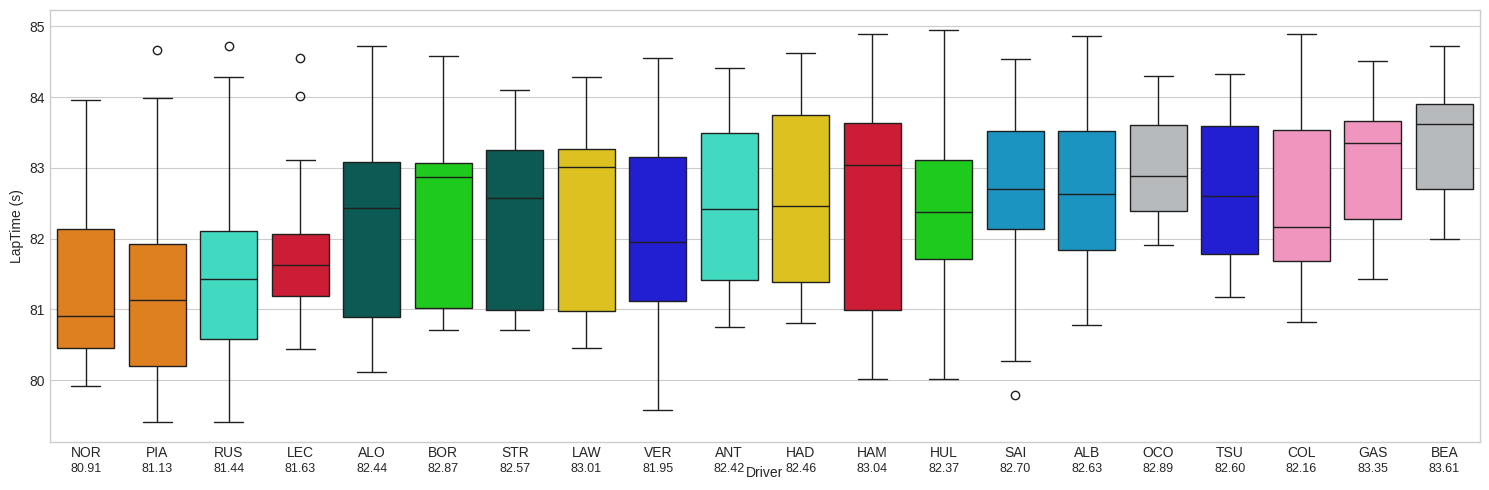

In [17]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x = transformed_laps['Driver'], y=transformed_laps['LapTime (s)'], palette=fastf1.plotting.get_driver_color_mapping(session=race))

# Add median lap time values below x-axis labels
for i, driver in enumerate(transformed_laps['Driver'].unique()):
    median_lap_time = transformed_laps[transformed_laps['Driver'] == driver]['LapTime (s)'].median()
    ax.text(i, ax.get_ylim()[0] - 0.30, f'{median_lap_time:.2f}', ha='center', va='top', fontsize=9)

plt.tight_layout()
plt.show()

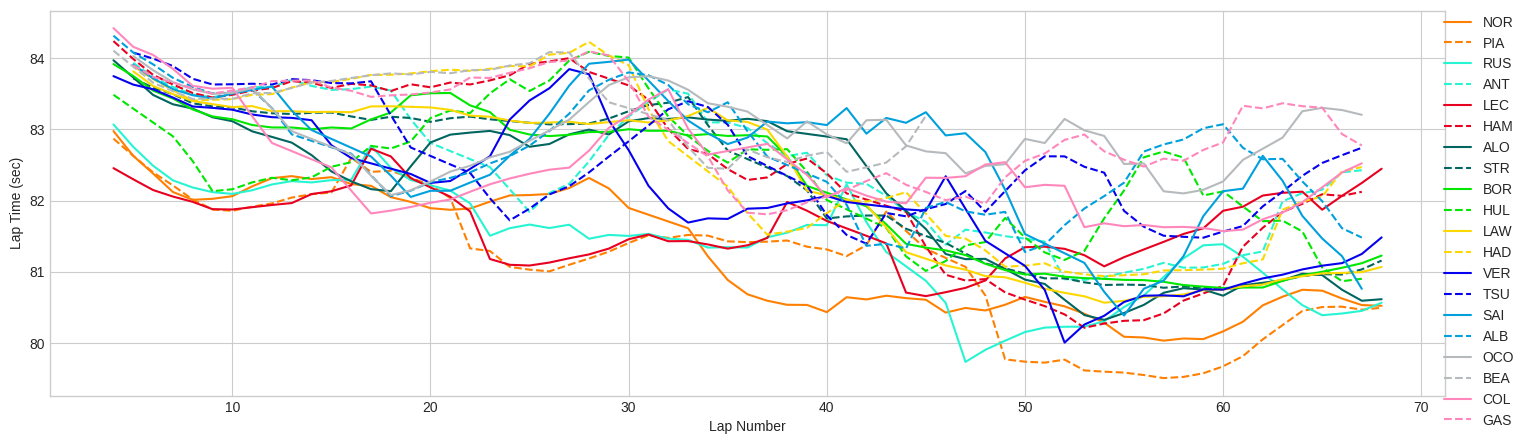

In [57]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 5))

# Calculate rolling average for smoothing
transformed_laps['LapTime (s)_smooth'] = transformed_laps.groupby('Driver')['LapTime (s)'].rolling(window=5, center=True).mean().reset_index(level=0, drop=True)

# Determine line style based on team and driver order
line_styles = {}
for team in transformed_laps['Team'].unique():
    team_drivers = transformed_laps[transformed_laps['Team'] == team]['Driver'].unique()
    if len(team_drivers) > 0:
        line_styles[team_drivers[0]] = '-'  # Solid line for the first driver
    if len(team_drivers) > 1:
        line_styles[team_drivers[1]] = '--' # Dashed line for the second driver

# Plot data for each driver with specified line styles
for driver, style in line_styles.items():
    driver_laps = transformed_laps[transformed_laps['Driver'] == driver]
    color = fastf1.plotting.get_driver_color(driver, session=race)
    ax.plot(driver_laps['LapNumber'], driver_laps['LapTime (s)_smooth'], label=driver, color=color, linestyle=style)

ax.set_xlabel('Lap Number')
ax.set_ylabel('Lap Time (sec)')
ax.legend(bbox_to_anchor=(0.99, 1.02), loc='upper left')
plt.show()